In [1]:
import sys
sys.path.append('/home/hashmi/ResearchBook/Tracking/Notebooks')
from central_import import *

figure_directory = '../../Figures/ModelCompare/'
os.makedirs(figure_directory,exist_ok=True)
set_plot_style()

In [2]:
#Calling the input file and shuffling the dataset
data = pd.read_parquet('../DataBuild/DownstreamTrackTrainingData.parquet').sample(frac=1,random_state=51)


#Defining Target Variable
x=data.drop(['isMatched'],axis=1)
y=data['isMatched'].astype(int)

columns=np.array(['P','Pt','Tx','Ty','Eta','Phi', 'X','Y','nUTHits','Chi2PerDoF'])
x.columns=columns

#Training Data
print(f"Dimension of the Data is : ",x.shape)
display(x.head())


Dimension of the Data is :  (55502, 10)


,P,Pt,Tx,Ty,Eta,Phi,X,Y,nUTHits,Chi2PerDoF
29055,12036.225731,441.439316,-0.008233,-0.035765,-14.409651,-85.211197,3.998446,-1.797049,4,0.573259
364,10226.238916,216.763108,-0.002195,0.021088,-9.130033,50.204380,4.546942,1.674532,4,0.274051
52050,4525.161110,690.376942,0.080474,-0.131736,192.606689,-308.244781,2.567447,-1.022417,4,0.158477
48683,1699.675633,173.988433,-0.090601,0.048797,-262.288910,139.731888,2.969721,2.647554,4,0.875791
41671,21602.894387,1136.739709,-0.025342,0.046198,-55.272568,106.054962,3.637117,2.072528,4,0.205129


In [3]:
#Train-Test-Evaluation Split
x_train,x_temp,y_train,y_temp=train_test_split(x,y,stratify=y,random_state=51)
x_test,x_eval,y_test,y_eval=train_test_split(x_temp,y_temp,stratify=y_temp,random_state=51)

#Preprocessing of Train-Test Data
x_train=pd.DataFrame(scaler.fit_transform(x_train),columns=x.columns)
x_test=pd.DataFrame(scaler.transform(x_test),columns=x.columns)
x_eval=pd.DataFrame(scaler.transform(x_eval),columns=x.columns)
x_train,y_train=sampler.fit_resample(x_train,y_train)
x_eval,y_eval=sampler.fit_resample(x_eval,y_eval)

In [4]:
rocScores=[]
f1Scores=[]
for model in models_:
    model.fit(x_train,y_train)
    # Model Evaluation (Balanced Data)
    y_predict=model.predict(x_test)
    rocScores.append(round(roc_auc_score(y_test,y_predict)*100,2))
    f1Scores.append(round(f1_score(y_test,y_predict)*100,2))
    print(model)
    print(f'ROC-AUC Score : ',round(roc_auc_score(y_test,y_predict)*100,2),'%')
    print(f'F1 Score : ',round(f1_score(y_test,y_predict)*100,2),'%')

modelMetrics=pd.DataFrame(modelNames,columns=["ModelNames"])
modelMetrics['ROC']=rocScores
modelMetrics['F1']=f1Scores
modelMetrics.to_csv("ModelMetrics.csv",index=False)


LogisticRegression()
ROC-AUC Score :  66.72 %
F1 Score :  77.95 %
DecisionTreeClassifier()
ROC-AUC Score :  64.5 %
F1 Score :  76.88 %
RandomForestClassifier()
ROC-AUC Score :  71.08 %
F1 Score :  82.51 %
GradientBoostingClassifier()
ROC-AUC Score :  71.39 %
F1 Score :  83.74 %
AdaBoostClassifier()
ROC-AUC Score :  69.62 %
F1 Score :  82.45 %
KNeighborsClassifier()
ROC-AUC Score :  67.09 %
F1 Score :  81.16 %
MLPClassifier()
ROC-AUC Score :  69.88 %
F1 Score :  85.69 %
ROC-AUC Score :  73.79 %
F1 Score :  85.54 %


In [5]:
modelMetrics=pd.read_csv("ModelMetrics.csv")

In [6]:
modelMetrics

,ModelNames,ROC,F1
0,Logistic,66.72,77.95
1,DecisionTree,64.50,76.88
2,RandomForest,71.08,82.51
3,GradientBoosting,71.39,83.74
4,AdaBoost,69.62,82.45
5,KNN,67.09,81.16
6,MLP,69.88,85.69
7,CatBoost,73.79,85.54


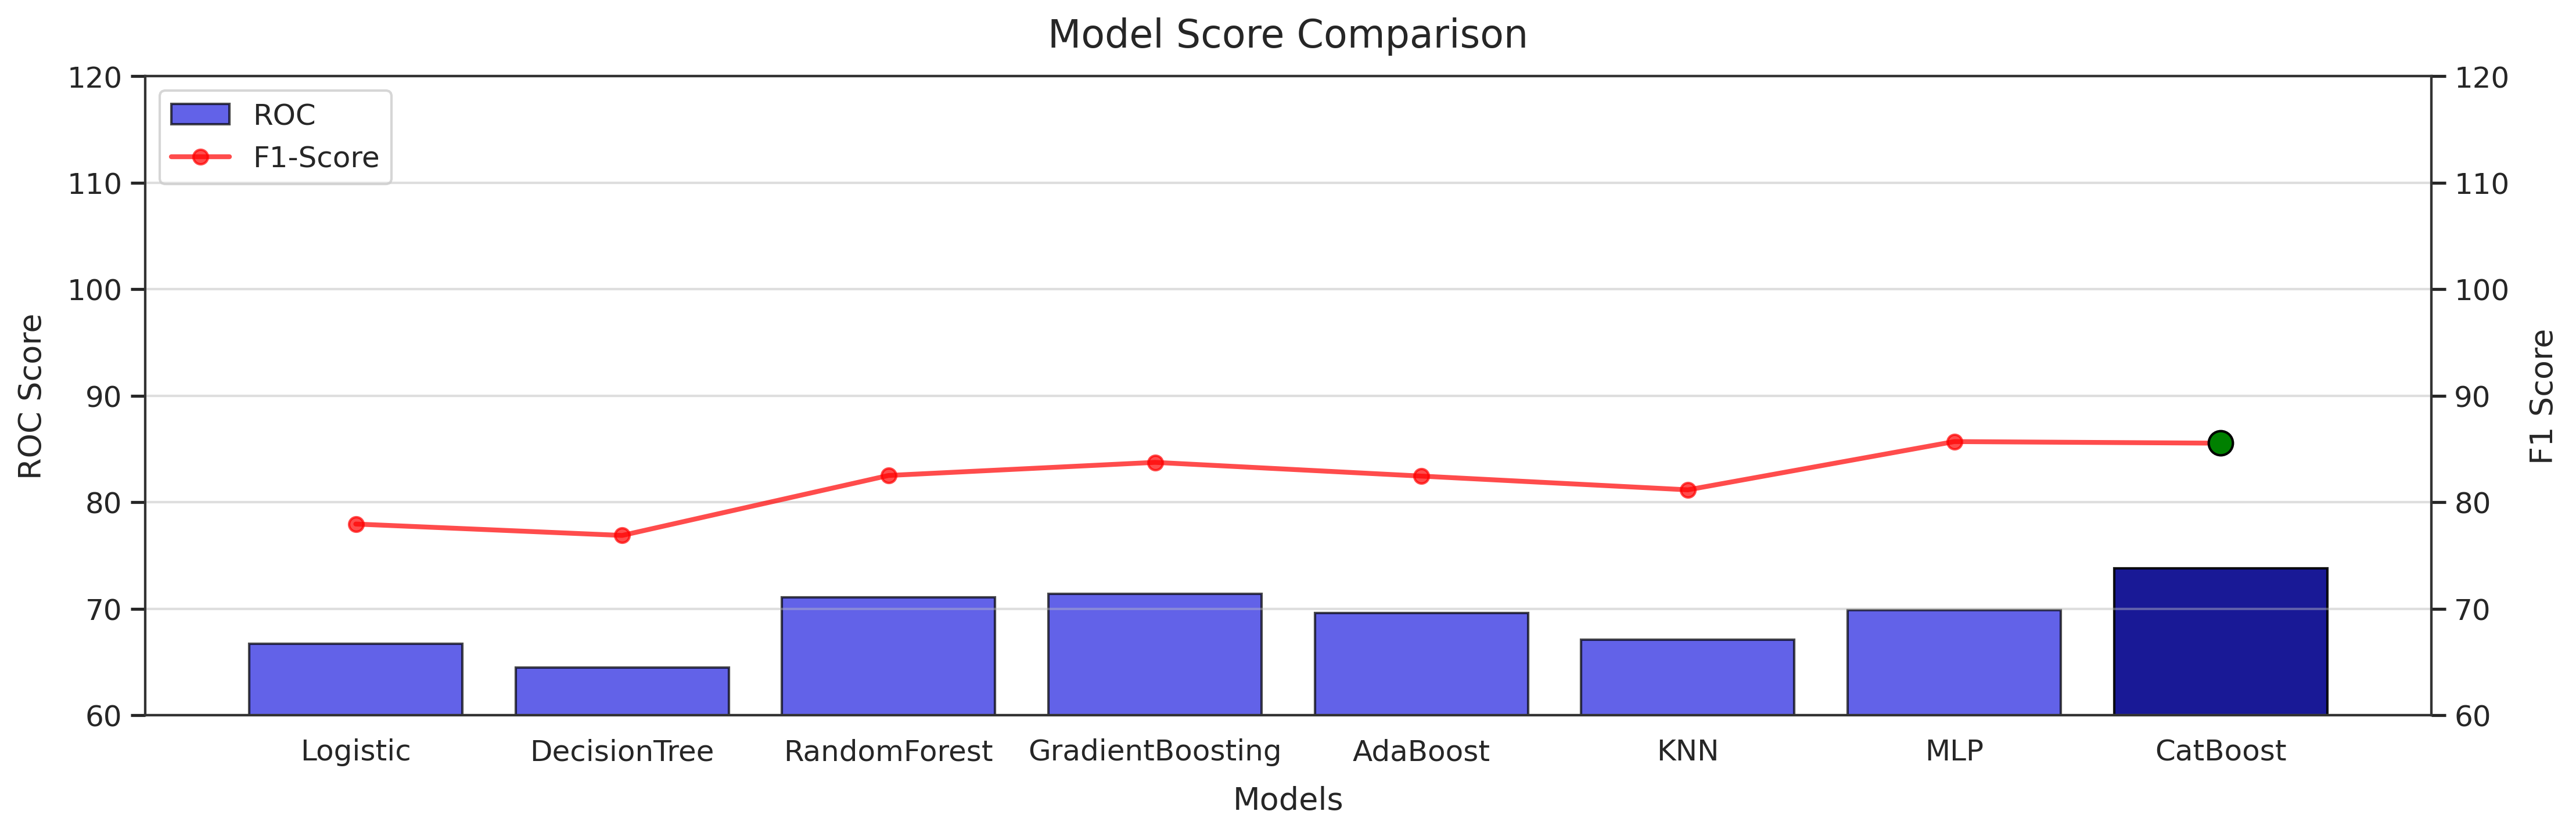

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot all ROC bars except the last one
sns.barplot(
    x="ModelNames",
    y="ROC",
    data=modelMetrics.iloc[:-1],
    color='blue',
    edgecolor='black',
    alpha=0.7,
    ax=ax,
    label='ROC'
)

# Plot the last ROC bar differently
last_idx = modelMetrics.index[-1]
ax.bar(
    modelMetrics.loc[last_idx, 'ModelNames'],
    modelMetrics.loc[last_idx, 'ROC'],
    color='darkblue',
    edgecolor='black',
    alpha=0.9
)

# Plot the F1-score as a line
ax2 = ax.twinx()
ax2.plot(
    modelMetrics['ModelNames'],
    modelMetrics['F1'],
    color='red',
    marker='o',
    linewidth=2,
    alpha=0.7,
    label='F1-Score'
)

# Highlight last F1-score marker differently
ax2.plot(
    modelMetrics.loc[last_idx, 'ModelNames'],
    modelMetrics.loc[last_idx, 'F1'],
    marker='o',
    markersize=10,
    markerfacecolor='green',
    markeredgecolor='black',
)

# Axis and title
ax.set_xlabel("Models")
ax.set_ylabel("ROC Score")
ax2.set_ylabel("F1 Score")
ax.set_ylim(60, 120)
ax2.set_ylim(60, 120)
plt.title("Model Score Comparison")


handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

# Tight layout
plt.tight_layout()
plt.savefig(f"{figure_directory}/Downstream_ModelCompare.png")
plt.show()


In [8]:
# End of notebook